## Cosmological parameter estimation: MCMC, GA and GA-Fisher

In this notebook we show how cosmological parameters can be estimated using the traditional MCMC (through `emcee`) and compare this to GA and GA-Fisher. See [arXiv:2505.10450](https://arxiv.org/abs/2505.10450) for details.

In [ ]:
import os, sys
import numpy as np
import numdifftools as nd

import matplotlib.pyplot as plt
import corner

from mcmcee import run_mcmc
from ga_pygad import GeneticAlgorithm
from scipy.optimize import minimize
from astropy.cosmology import LambdaCDM

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

### 0. Load data

In [3]:
# import the data points
filename = 'https://gitlab.com/mmoresco/CCcovariance/-/raw/master/data/HzTable_MM_BC03.dat'
z_cc, Hz_cc, errHz_cc = np.genfromtxt(filename, comments = '#', usecols = (0,1,2), \
                                      unpack = True, delimiter = ',')

# import and calculate covariance matrix
# import CC covariance matrix data

filename = 'https://gitlab.com/mmoresco/CCcovariance/-/raw/master/data/data_MM20.dat'
zmod, imf, slib, sps, spsooo = np.genfromtxt(filename, comments = '#', \
                                             usecols = (0,1,2,3,4), unpack = True)

# calculate CC covariance matrix
cov_mat_diag = np.zeros((len(z_cc), len(z_cc)), dtype = 'float64')

for i in range(len(z_cc)):
    cov_mat_diag[i,i] = errHz_cc[i]**2

imf_intp = np.interp(z_cc, zmod, imf)/100
slib_intp = np.interp(z_cc, zmod, slib)/100
sps_intp = np.interp(z_cc, zmod, sps)/100
spsooo_intp = np.interp(z_cc, zmod, spsooo)/100

cov_mat_imf = np.zeros((len(z_cc), len(z_cc)), dtype = 'float64')
cov_mat_slib = np.zeros((len(z_cc), len(z_cc)), dtype = 'float64')
cov_mat_sps = np.zeros((len(z_cc), len(z_cc)), dtype = 'float64')
cov_mat_spsooo = np.zeros((len(z_cc), len(z_cc)), dtype = 'float64')

for i in range(len(z_cc)):
    for j in range(len(z_cc)):
        cov_mat_imf[i,j] = Hz_cc[i] * imf_intp[i] * Hz_cc[j] * imf_intp[j]
        cov_mat_slib[i,j] = Hz_cc[i] * slib_intp[i] * Hz_cc[j] * slib_intp[j]
        cov_mat_sps[i,j] = Hz_cc[i] * sps_intp[i] * Hz_cc[j] * sps_intp[j]
        cov_mat_spsooo[i,j] = Hz_cc[i] * spsooo_intp[i] * Hz_cc[j] * spsooo_intp[j]

C_cc = cov_mat_spsooo + cov_mat_imf + cov_mat_diag # full CC covariance
C_cc_inv = np.linalg.inv(C_cc)


# import supernovae data
loc_lcparam = 'https://github.com/PantheonPlusSH0ES/DataRelease/raw/main/\
Pantheon%2B_Data/4_DISTANCES_AND_COVAR/Pantheon%2BSH0ES.dat'

# pantheon plus systematics
lcparam = np.loadtxt(loc_lcparam, skiprows = 1, usecols = (2, 8, 9, 10, 11))

# setup pantheon samples with z > 0.01
z_pp = lcparam[:, 0][111:]
mMz_pp = lcparam[:, 3][111:]
sigmMz_pp = lcparam[:, 4][111:]

# load the pantheon+ covariance matrix

loc_lcparam_sys = 'https://raw.githubusercontent.com/PantheonPlusSH0ES/\
DataRelease/main/Pantheon%2B_Data/4_DISTANCES_AND_COVAR/Pantheon%2BSH0ES_STAT%2BSYS.cov'

lcparam_sys = np.loadtxt(loc_lcparam_sys, skiprows = 1)

# pantheon plus systematics
C_sne = lcparam_sys.reshape(1701, 1701)
C_sne_inv = np.linalg.inv(C_sne[111:, 111:])

### 1. Cosmological model

We use `astropy` to make predictions; three examples are used below for visualization (feel free to play with this);

In [4]:
z_test=np.logspace(np.log10(min(z_pp))-0.1, np.log10(max(z_pp))+0.1)

# reference cosmologies
H0_test, Om0_test, Ok0_test = 73, 0.3, 0.0
cosmo = LambdaCDM(H0 = H0_test, Om0 = Om0_test, Ode0 = 1-Om0_test-Ok0_test)
Hz_test = cosmo.H(z_test).value
mMz_test = cosmo.distmod(z_test).value


H0_test, Om0_test, Ok0_test = 68, 0.3, 0.0
cosmo = LambdaCDM(H0 = H0_test, Om0 = Om0_test, Ode0 = 1-Om0_test-Ok0_test)
Hz_test_1 = cosmo.H(z_test).value
mMz_test_1 = cosmo.distmod(z_test).value


H0_test, Om0_test, Ok0_test = 68, 0.3, 0.1
cosmo = LambdaCDM(H0 = H0_test, Om0 = Om0_test, Ode0 = 1-Om0_test-Ok0_test)
Hz_test_2 = cosmo.H(z_test).value
mMz_test_2 = cosmo.distmod(z_test).value

Plots of the predictions vs data are shown below;

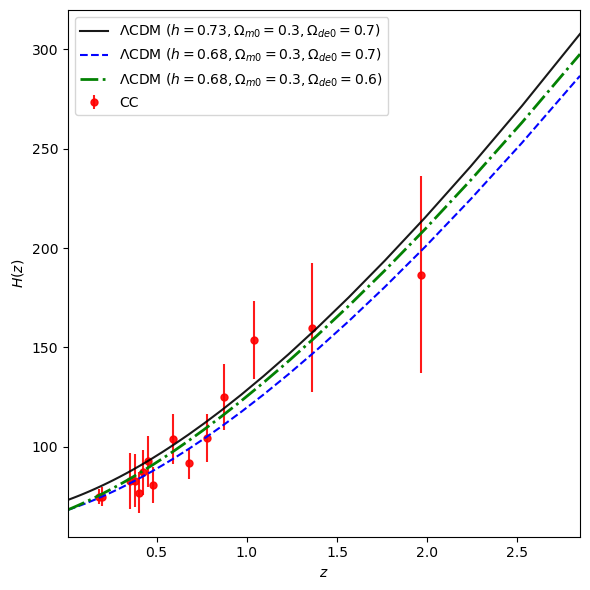

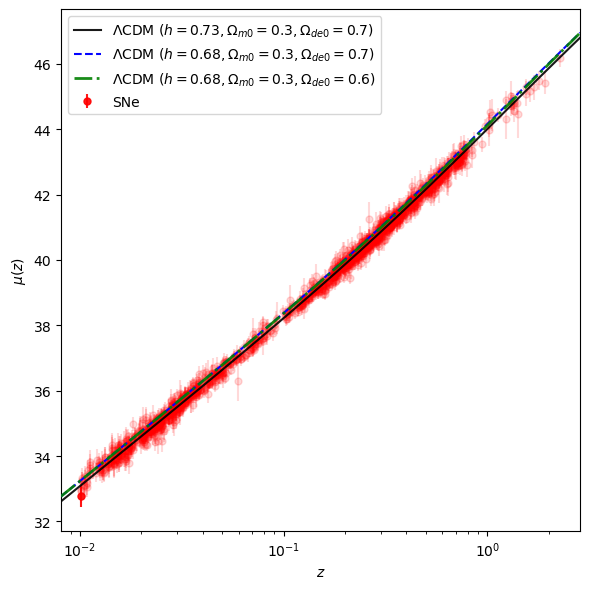

In [5]:
# plot to visualize
fig, ax = plt.subplots(figsize=(6,6))
ax.errorbar(z_cc, Hz_cc, yerr = errHz_cc, fmt = 'ro', markersize = 5, zorder=0, alpha=0.9, label='CC', rasterized=True)
ax.plot(z_test, Hz_test, 'k-', alpha=0.9, label=r'$\Lambda$CDM ($h=0.73, \Omega_{m0}=0.3, \Omega_{de0}=0.7$)')
ax.plot(z_test, Hz_test_1, 'b--', alpha=0.99, label=r'$\Lambda$CDM ($h=0.68, \Omega_{m0}=0.3, \Omega_{de0}=0.7$)')
ax.plot(z_test, Hz_test_2, 'g-.', alpha=0.99, linewidth=2, label=r'$\Lambda$CDM ($h=0.68, \Omega_{m0}=0.3, \Omega_{de0}=0.6$)')
ax.set_xlabel(r'$z$'); ax.set_ylabel(r'$H(z)$')
ax.set_xlim(min(z_test), max(z_test))
ax.legend(loc='upper left')
fig.tight_layout()
# fig.savefig('./figs/CC_data_and_model.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(6,6))
ax.errorbar(z_pp, mMz_pp, yerr = sigmMz_pp, fmt = 'ro', markersize = 5, alpha=0.15, rasterized=True)
ax.errorbar(z_pp[0], mMz_pp[0], yerr = sigmMz_pp[0], fmt = 'ro', markersize = 5, alpha=0.9, label='SNe', rasterized=True)
ax.plot(z_test, mMz_test, 'k-', alpha=0.9, zorder=100, label=r'$\Lambda$CDM ($h=0.73, \Omega_{m0}=0.3, \Omega_{de0}=0.7$)')
ax.plot(z_test, mMz_test_1, 'b--', alpha=0.99, zorder=99, label=r'$\Lambda$CDM ($h=0.68, \Omega_{m0}=0.3, \Omega_{de0}=0.7$)')
ax.plot(z_test, mMz_test_2, 'g-.', alpha=0.9, linewidth=2, zorder=101, label=r'$\Lambda$CDM ($h=0.68, \Omega_{m0}=0.3, \Omega_{de0}=0.6$)')
ax.set_xscale('log')
ax.set_xlabel('$z$'); ax.set_ylabel('$\mu(z)$')
ax.set_xlim(min(z_test), max(z_test))
ax.legend(loc='upper left')
fig.tight_layout()
# fig.savefig('./figs/SNe_data_and_model.pdf', bbox_inches='tight')
plt.show()

### 2. Likelihood and priors

We setup likelihood and priors given our model and cosmological data.

In [6]:
def Chi2_CC(x):
    # H0, Om0, Ok0 = x
    # cosmo = LambdaCDM(H0=H0, Om0=Om0, Ode0=1-Om0-Ok0)
    H0, Om0, Ode0 = x
    cosmo = LambdaCDM(H0=H0, Om0=Om0, Ode0=Ode0)
    dev_cc = Hz_cc - cosmo.H(z_cc).value
    return dev_cc.T @ C_cc_inv @ dev_cc

def Chi2_SNe(x):
    # H0, Om0, Ok0 = x
    # cosmo = LambdaCDM(H0=H0, Om0=Om0, Ode0=1-Om0-Ok0)
    H0, Om0, Ode0 = x
    cosmo = LambdaCDM(H0=H0, Om0=Om0, Ode0=Ode0)
    dev_sne = mMz_pp - cosmo.distmod(z_pp).value
    return dev_sne.T @ C_sne_inv @ dev_sne


# add flat priors
H0_min, H0_max = 0, 100
Om0_min, Om0_max = 0, 1
Ode0_min, Ode0_max = 0, 1

def llflatprior(x):
    H0, Om0, Ode0 = x
    # if (H0_min < H0 < H0_max and Om0_min < Om0 < Om0_max \
    #     and Ok0_min < Ok0 < Ok0_max):
    if (H0_min < H0 < H0_max and Om0_min < Om0 < Om0_max \
        and Ode0_min < Ode0 < Ode0_max):
        return 0.0
    return -np.inf

def llprob_CC(x):
    H0, Om0, Ode0 = x
    if (Om0 < 0) or (H0 < 0):
        return -np.inf
    lp = llflatprior(x)
    lk = -0.5*Chi2_CC(x)
    if np.isnan(lk):
        return -np.inf
    return lp + lk if np.isfinite(lp) else -np.inf

def llprob_CCSNe(x):
    H0, Om0, Ode0 = x
    if (Om0 < 0) or (H0 < 0):
        return -np.inf
    lp = llflatprior(x)
    lk = -0.5*(Chi2_CC(x) + Chi2_SNe(x))
    if np.isnan(lk):
        return -np.inf
    return lp + lk if np.isfinite(lp) else -np.inf

### 3. Performing MCMC

Now, we perform MCMC using the CC only data set. As usual, we first obtain the maximum of the likelihood for optimal performance;

In [7]:
# CC only
print('searching the initial position ...')
rest = minimize(lambda x: -llprob_CC(x), [70, 0.3, 0.7], method = 'Nelder-Mead')
print('minimization 0.5*chi2', rest.x)
result = rest.x

searching the initial position ...
minimization 0.5*chi2 [69.46533001  0.54339757  0.99999619]


MCMC is now performed below;

In [9]:
ndim, nwalkers = 3, 12
nburn = 100
nmcmc = 4000
dres = [0.01, 0.001, 0.001]

samps_mcmc = run_mcmc(ndim, nwalkers, nburn, nmcmc, dres, llprob_CC, p0 = result);

Running MCMC...


100%|██████████| 4000/4000 [01:02<00:00, 64.09it/s]

Done.
Mean acceptance fraction: 0.60075
Total time: 63.66384482383728
MCMC result:
    x[0] = 65.06886957971201 + 5.880686029551782 - 5.591144741483163
    x[1] = 0.3531394217821271 + 0.20992371857494707 - 0.19083040447383542
    x[2] = 0.6159820713723452 + 0.261143561713833 - 0.32675240522873866


We play the same game with CC + SNe data set; as follows

In [10]:
# CC + SNe
print('searching the initial position ...')
rest = minimize(lambda x: -llprob_CCSNe(x), [70, 0.3, 0.7], method = 'Nelder-Mead')
print('minimization 0.5*chi2', rest.x)
result = rest.x

searching the initial position ...
minimization 0.5*chi2 [73.2164373   0.30542382  0.64123532]


Then, MCMC is performed as

In [10]:
ndim, nwalkers = 3, 12
nburn = 100
nmcmc = 4000
dres = [0.01, 0.001, 0.001]

samps_mcmc_ccsne = run_mcmc(ndim, nwalkers, nburn, nmcmc, dres, llprob_CCSNe, p0 = result);

Running MCMC...


100%|██████████| 4000/4000 [03:42<00:00, 17.98it/s]


Done.
Mean acceptance fraction: 0.6482083333333334
Total time: 228.0505633354187
MCMC result:
    x[0] = 73.21590036674333 + 0.27805887689451936 - 0.2853527594707117
    x[1] = 0.3050548653778289 + 0.05143964583209121 - 0.05229050192599832
    x[2] = 0.6410353006288837 + 0.0776780248897262 - 0.07893267025602868


We save the results for CC + SNe which we will use to generate Figure 6 of [arXiv:2505.10450](https://arxiv.org/abs/2505.10450);

In [ ]:
np.savetxt('./data/mcmc_ccsne.txt', samps_mcmc_ccsne)

### 4. Performing GA

Now the analogous GA results can be obtained using `pygad` as follows; for CC only data

In [ ]:
rest = minimize(lambda x: -llprob_CC(x), [70, 0.3, 0.7], method = 'Nelder-Mead')
print('minimization 0.5*chi2', rest.x)
prior = [[H0_min, H0_max], [Om0_min, Om0_max], [Ode0_min, Ode0_max]]
ga = GeneticAlgorithm(llprob=llprob_CC, prior=prior, p0=rest.x, \
                      pop_size=3000, n_gen=100, sel_rate=0.3, \
                      crossover_prob=0.3, mutation_prob=[0.5, 0.3], \
                      parent_selection_type="rws", crossover_type="scattered", \
                      mutation_type="adaptive", num_threads=os.cpu_count())

# run genetic algorithm
ga_sol, solution_fitness, solution_idx = ga.run_ga()
print(ga_sol)

minimization 0.5*chi2 [69.46533001  0.54339757  0.99999619]
[69.41899579  0.54323642  0.99303017]


And for CC + SNe data set, we have

In [ ]:
rest = minimize(lambda x: -llprob_CCSNe(x), [70, 0.3, 0.7], method = 'Nelder-Mead')
print('minimization 0.5*chi2', rest.x)
prior = [[H0_min, H0_max], [Om0_min, Om0_max], [Ode0_min, Ode0_max]]
ga = GeneticAlgorithm(llprob=llprob_CCSNe, prior=prior, p0=rest.x, \
                      pop_size=5000, n_gen=100, sel_rate=0.3, \
                      crossover_prob=0.3, mutation_prob=[0.8, 0.2], \
                      parent_selection_type="rws", crossover_type="scattered", \
                      mutation_type="adaptive", num_threads=os.cpu_count())

# run genetic algorithm
ga_instance=ga.run_ga()

minimization 0.5*chi2 [73.2164373   0.30542382  0.64123532]


/home/reggie_apctp/miniconda3/envs/cosmo/lib/python3.11/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


We save the results for the CC + SNe data set which will be used to generate Figure 6;

In [ ]:
ga_instance.save("./data/ga_ccsne")

### Reproducing Figure 6 of [arXiv:2505.10450](https://arxiv.org/abs/2505.10450)

Lastly we reproduce Figure 6 of the paper; we use the GA and MCMC stored output;

In [15]:
import sys
import astropy.cosmology.flrw as flrw
sys.modules['astropy.cosmology.flrw.lambdacdm'] = flrw
sys.modules['astropy.cosmology.flrw'] = flrw

import pygad

ga_instance=pygad.load('data/ga_ccsne')

The GA best fit solution is given by;

In [16]:
ga_sol, solution_fitness, solution_idx = ga_instance.best_solution()
print(ga_sol)

[73.19487885  0.29205341  0.62152319]


We use this to evaluate Fisher matrix uncertainty estimate;

In [17]:
# surround GA best fit with covariance from Fisher matrix
FisherM = -nd.Hessian(llprob_CCSNe)(ga_sol)
cov_FisherM = np.linalg.inv(FisherM)
samps_gaFisher_ccsne = np.random.multivariate_normal(ga_sol, cov_FisherM, size=(4000-100)*12)

/Users/rechbe/miniconda3/envs/cosmoga/lib/python3.11/site-packages/astropy/cosmology/_src/flrw/base.py:1179: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(self._inv_efunc_scalar, z1, z2, args=self._inv_efunc_scalar_args)[0]


Loading the MCMC results;

In [12]:
samps_mcmc_ccsne=np.loadtxt('./data/mcmc_ccsne.txt')

Now finally here is the figure reproduced;

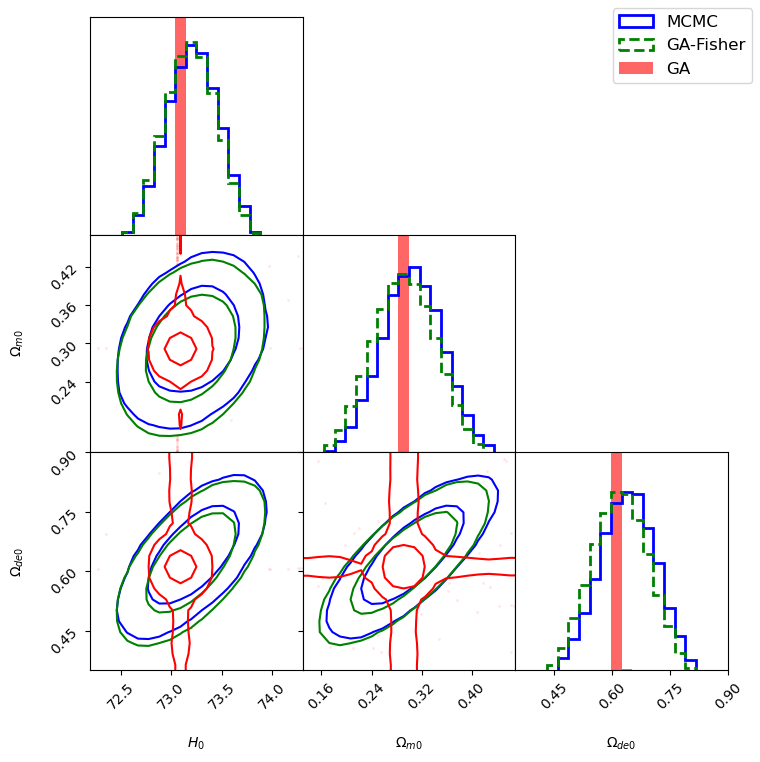

In [20]:
# trimming outliers using IQR method for better visualization
def remove_outliers_iqr(data, threshold=1.5):
    q1 = np.percentile(data, 25, axis=0)
    q3 = np.percentile(data, 75, axis=0)
    iqr = q3 - q1
    lower_bound = q1 - threshold * iqr
    upper_bound = q3 + threshold * iqr
    
    # identify outliers
    outliers_mask = np.any((data < lower_bound) | (data > upper_bound), axis=1)
    
    # remove outliers
    cleaned_data = data[~outliers_mask]
    
    return cleaned_data


labels = [r'$H_0$', r'$\Omega_{m0}$', r'$\Omega_{de0}$'] 
range=[(72.2,74.3), (0.13,0.47), (0.35,0.9)]
fig = corner.corner(samps_mcmc_ccsne, labels=labels, levels=(0.68, 0.95), \
                    color='blue', label='MCMC: CC+SNe', normalize=True, \
                    plot_datapoints=False, show_titles=False, \
                    fill_contours=False, smooth=True, plot_density=False, \
                    range=range, \
                    hist_kwargs={'linestyle': '-', 'linewidth': 2, 'density': True, 'alpha':1})
corner.corner(samps_gaFisher_ccsne, fig=fig, labels=labels, levels=(0.68, 0.95), \
              color='green', label='GA-Fisher: CC+SNe', normalize=True, \
              plot_datapoints=False, show_titles=False, \
              fill_contours=False, smooth=True, plot_density=False, range=range, \
              hist_kwargs={'linestyle': '--', 'linewidth': 2, 'density': True, 'alpha':1})
corner.corner(ga_instance.population, fig=fig, labels=labels, levels=(0.68, 0.95), \
              color='red', label='GA: CC+SNe', normalize=True, \
              plot_datapoints=True, show_titles=False, \
              fill_contours=False, smooth=True, plot_density=False, range=range, \
              hist_kwargs={'linestyle': ':', 'linewidth': 2, 'density': True, 'alpha':0.6, 'histtype': 'stepfilled'})

fig.axes[0].set_ylim(0.1,1.6)
fig.axes[4].set_ylim(0.3,9)
fig.axes[8].set_ylim(0.3,6)

fig.axes[3].set_yticks([0.24, 0.30, 0.36, 0.42])

fig.legend(['MCMC', 'GA-Fisher', 'GA'], loc='upper right', prop={'size': 12})
fig.tight_layout()
fig.subplots_adjust(hspace=0, wspace=0)
# fig.savefig('figs/mcmc_ga_lcdm_constraints.pdf', bbox_inches='tight')
plt.show()